In [1]:
import sys 

import sklearn
import numpy as np 
import os
import pandas as pd
import time

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.datasets import fetch_openml
import matplotlib as mpl
import matplotlib.pyplot as plt

from IPython.utils import io

from sklearn.model_selection import train_test_split

In [2]:
df_train = pd.read_csv("./data/mnist/fashion-mnist_train.csv")
df_test = pd.read_csv("./data/mnist/fashion-mnist_test.csv")

y_train_full = df_train.label
y_test = df_test.label

x_train_full = df_train.drop("label", axis=1).to_numpy()
x_test = df_test.drop("label", axis=1).to_numpy()

x_train,x_validate,y_train,y_validate = train_test_split(x_train_full,y_train_full)


In [3]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
x_reduced = pca.fit_transform(x_train)
x_recovered = pca.inverse_transform(x_reduced)

In [4]:
def plot_pictures(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")



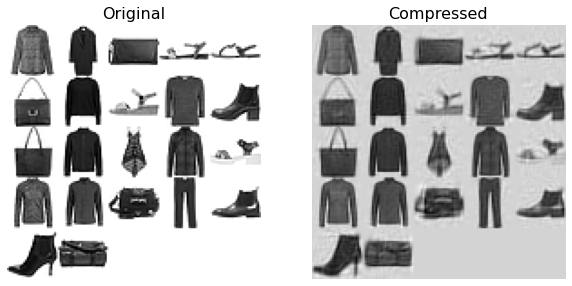

In [5]:
with io.capture_output() as captured:
    plt.figure(figsize=(10, 10))
    plt.subplot(121)
    plot_pictures(x_train[::2100])
    plt.title("Original", fontsize=16)
    plt.subplot(122)
    plot_pictures(x_recovered[::2100])
    plt.title("Compressed", fontsize=16)

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score


preprocess = Pipeline([
    ('scaler',StandardScaler(with_std=False)),
    ('pca',PCA(n_components=30)),
])

x_reduced = preprocess.fit_transform(x_train)
x_validate_reduced = preprocess.transform(x_validate)

In [7]:
x_validate_reduced.shape

(15000, 30)

In [8]:


from sklearn.neighbors import KNeighborsClassifier

knn_clf =  KNeighborsClassifier(n_neighbors=5,n_jobs=-1)

knn_clf.fit(x_reduced,y_train)
knn_clf.score(x_validate_reduced,y_validate)


0.8508666666666667

In [9]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100,n_jobs=-1)

rf_clf.fit(x_reduced,y_train)
rf_clf.score(x_validate_reduced,y_validate)


0.8585333333333334

from sklearn.dummy import DummyClassifier

dc_clf = DummyClassifier(strategy="most_frequent")

dc_clf.fit(x_reduced,y_train)
dc_clf.score(x_validate_reduced,y_validate)

from sklearn.cluster import 

kmeans_clf = KMeans(n_clusters=25, random_state=0)

kmeans_clf.fit(x_reduced,y_train)
kmeans_clf.score(x_validate_reduced,y_validate)


from sklearn.naive_bayes import GaussianNB


gnb_clf =  GaussianNB()

gnb_clf.fit(x_reduced,y_train)
gnb_clf.score(x_validate_reduced,y_validate)

from sklearn.tree import DecisionTreeClassifier
ada_clf =  AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),n_estimators=200,learning_rate=0.2)

ada_clf.fit(x_reduced,y_train)
ada_clf.score(x_validate_reduced,y_validate)

In [10]:
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(eta=0.3,max_depth=10, eval_metric='mlogloss')
#xgb_clf.fit(x_reduced,y_train)
#xgb_clf.score(x_validate_reduced,y_validate)

0.871

In [11]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[('knn',knn_clf),
                ('rf',rf_clf),
                ('xgb',xgb_clf)],
            voting='soft',
            weights=[1,1,4],
)
voting_clf.fit(x_reduced, y_train)
voting_clf.score(x_validate_reduced,y_validate)

0.8706666666666667

from sklearn.ensemble import StackingClassifier

stacking_clf = StackingClassifier(
    estimators=[('knn',knn_clf),
                ('rf',rf_clf),
                ('xgb',xgb_clf)]
)
stacking_clf.fit(x_reduced, y_train)
stacking_clf.score(x_validate_reduced,y_validate)

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(voting_clf,x_train,y_train,cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)

output_labels = ["top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

with io.capture_output() as captured:
    row_sums = conf_mx.sum(axis=1, keepdims=True)
    norm_conf_mx = conf_mx / row_sums

    figure = plt.figure(figsize=(12, 10)) 
    axes = figure.add_subplot(111) 

    np.fill_diagonal(norm_conf_mx, 0)
    caxes = axes.matshow(norm_conf_mx, cmap=plt.cm.gray)
    figure.colorbar(caxes) 

    axes.set_xticklabels(output_labels) 
    axes.set_xticks(np.arange(10))
    axes.set_yticks(np.arange(10))
    axes.set_yticklabels(output_labels) 
    
plt.show()

In [15]:
preprocess = Pipeline([
    ('scaler',StandardScaler(with_std=False)),
    ('pca',PCA(n_components=0.95)),
])

x_reduced = preprocess.fit_transform(x_train)
x_validate_reduced = preprocess.transform(x_validate)


from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[('knn',knn_clf),
                ('rf',rf_clf),
                ('xgb',xgb_clf)],
            voting='soft',
            weights=[1,1,4],
)
voting_clf.fit(x_reduced, y_train)
voting_clf.score(x_validate_reduced,y_validate)

0.8804